## Jupyter notebook to read XRR data and convert to Qx-Qz maps
Reads ".csv" files written by Panalytical XRD system

M.R. Fitzsimmons

Version 1.0

29July2020

30.07.20 Added error propogation and output file writing

## Import and function defintions

In [1]:
import os
%cd ~
cwd_path = os.getcwd()
print('Current working directory: %s'%cwd_path)

import re
import numpy as np
from numpy import nan
import scipy.io as sio
import scipy.interpolate as interpolate
from scipy.interpolate import griddata
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.colors as colors
import copy

# function obtained from 
# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
# and modified to return the index (idx) and array value (array[idx]) closes to the target.
def find_nearest(array, target):
    array = np.asarray(array)
    idx = (np.abs(array - target)).argmin()
    return array[idx],idx

# use with curvefit
def curve_line(x,a,b,c,d):
    g = np.abs(a + b*x + c*(x-d)**2)
    return g

Pi = np.pi

/Users/mf3
Current working directory: /Users/mf3


## USER INPUT required here

Name of '.csv' file of data written by Panalytical.

Opportunity for user to customize ROI limits for background fitting.

In [2]:
DirectoryPath = cwd_path+r'/Dropbox (ORNL)/Project XRR/XRR q-binner/' # USER INPUT HERE
NameFile = 'example_data.csv' # USER INPUT HERE
OutputFileBase = DirectoryPath+'example' # USER INPUT HERE
try:
    InputFile = open(DirectoryPath+NameFile,'r')
    XrayData = InputFile.readlines()
    InputFile.close()
    print('Found data: %s'%NameFile)
except:
    print('No data found: %s'%NameFile)

UserBorder = False # Default system will use ROI from smallest omega to 0. for bottom strip and top 80% for upper strip.

# For custom Borders on background subtraction, set to True and set the borders as desired.
#UserBorder = True
#Border0, Border1 = 0., 2.  # in degrees defining a border measured from smallest omega up and largest omega down


Found data: example_data.csv


## Extract data

Calculate the weighted wavelength in Angstroms.

Record the time per step (leaving opportunity to normalize later).

Obtain axis titles to use later.

The raw data will be counts stored in array "z" with coordinates "x" and "y". Note lower case.

In [3]:
n = len(XrayData)

# get the wavelength
substr1 = 'K-Alpha1'
substr2 = 'K-Alpha2'
ratio = 0 # ratio of Ka2 to Ka1
for i in range(n):
    if(XrayData[i].find(substr1) == 0):
        kalpha1 = i
    if(XrayData[i].find(substr2) == 0):
        kalpha2 = i
    if(XrayData[i].find(substr1) > 0):
        ratio = i

x=re.findall("\d+\.\d+",XrayData[kalpha1])
kalpha1 = float(x[0])
x=re.findall("\d+\.\d+",XrayData[kalpha2])
kalpha2 = float(x[0])
x=re.findall("\d+\.\d+",XrayData[ratio])
ratio = float(x[0])
WaveLength = (1*kalpha1+ratio*kalpha2)/(1+ratio)

# get the time per step
substr1 = 'Time per step'
for i in range(n):
    if(XrayData[i].find(substr1) == 0):
        TimePerStep = i

x=re.findall("\d+\.\d+",XrayData[TimePerStep])
TimePerStep = float(x[0])

# get Axis titles
substr1 = '[Scan points]'
for i in range(n):
    if(XrayData[i].find(substr1) == 0):
        Trigger = i
s = XrayData[Trigger+1].split(',')
xAxisTitle = s[0]
yAxisTitle = s[1]
r = s[2].split('\n')
zAxisTitle = r[0]

# read the data
m = n - Trigger - 2
x = np.zeros(m, dtype=np.float32) # x will be x axis two_theta in real space plots
y = np.zeros(m, dtype=np.float32) # y will be y axis omega in real space plots
z = np.zeros(m, dtype=np.float32) # z is the count(x,y)
for i in range(m):
    s = XrayData[i+Trigger+2].split(',')
    x[i] = float(s[0])
    y[i] = float(s[1])
    z[i] = float(s[2])


## Plot the raw image of the data

Code to plot an image of the binned data. Number of bins given by the number of unique steps in x (=u) and y (=v). 
The binned counts are stored in "Z" with coordinates "X" and "Y".  Note the upper case.  The raw data are preserved.

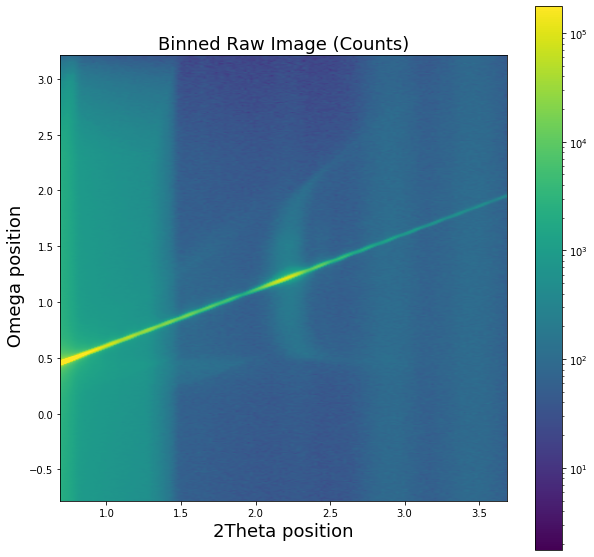

In [4]:
xmin, ymin = np.min(x),np.min(y)
xmax, ymax = np.max(x),np.max(y)
u,v = len(np.unique(x)), len(np.unique(y))
X,Y = np.arange(u)*(xmax - xmin)/(u-1) + xmin, np.arange(v)*(ymax - ymin)/(v-1) + ymin

Z = np.zeros((u,v), dtype=np.float32) # contains the binned data with coordinates X,Y; the unbinned remain x,y,z
for i in range(m):
    h,k = find_nearest(X,x[i])
    h,l = find_nearest(Y,y[i])
    Z[k,l] = Z[k,l] + z[i]

plt.figure(figsize = (10,10))
plt.xlabel(xAxisTitle,fontsize=18)
plt.ylabel(yAxisTitle,fontsize=18)
plt.title('Binned Raw Image (Counts)',fontsize=18)
#plt.imshow(np.transpose(Z,axes=[1,0]), extent=[xmin,xmax,ymin,ymax], aspect=(xmax-xmin)/(ymax-ymin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=np.max(Z)))
plt.imshow(np.transpose(Z,axes=[1,0]), extent=[xmin,xmax,ymin,ymax], aspect=(xmax-xmin)/(ymax-ymin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=1e-6*np.max(Z), vmax=1e-1*np.max(Z)))
plt.colorbar()
plt.show()


## Extract the omega offset
We assume the specular ridge is reasonably defined by where the maximum intensity is in omega for each 2theta value.
These are recorded and fitted to a line, i.e., omega_peak = intercept + slope * 2theta.  The coefficients of the best
fit are obtained. The raw omega coordinate, "y", is changed so that the intercept = 0 and the slope = 0.5. This
ensures when the conversion to Qx-Qz is made later, the specular ridge appears at Qx=0 for all Qz.

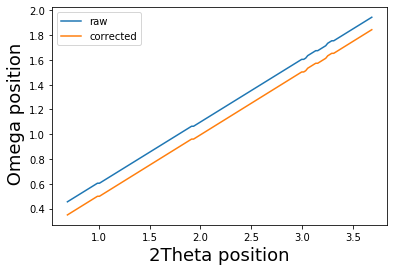

 Omega position offset: 0.107 (should be 0)
 Omega position slope: 0.498 (should be 0.5)


In [5]:
# find the value of omega corresponding to the specular ridge vs. 2theta
s = np.zeros(u, dtype=np.float32)
for i in range(u):
    p = np.argmax(Z[i,:])
    s[i] = Y[p]
    
coef = np.polyfit(X,s,1)
plt.xlabel(xAxisTitle,fontsize=18)
plt.ylabel(yAxisTitle,fontsize=18)
plt.plot(X,s,label='raw')
plt.plot(X,0.5*(s-coef[1])/coef[0],label='corrected')
plt.legend(loc='upper left')
plt.show()

print(yAxisTitle+' offset: %.3f (should be 0)'%coef[1])
print(yAxisTitle+' slope: %.3f (should be 0.5)'%coef[0])
#y = y - coef[1] # apply offset to the raw data, not the meshed data

y = 0.5*(y-coef[1])/coef[0] + 0 # we assume theta:2theta scan

## Re-evaluate the mesh and plot the offset-corrected image of the data
Having corrected "y", we reapply the code to ensure that the offset is zero an the slope is 0.5.

Finally, we define the variance of "z" as "var_z"

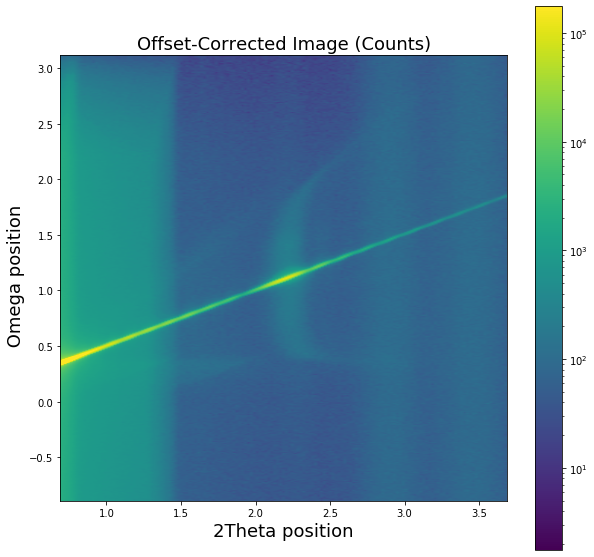

 Omega position offset: 0.000 (should be 0)
 Omega position slope: 0.500 (should be 0.5)


In [6]:
xmin, ymin = np.min(x),np.min(y)
xmax, ymax = np.max(x),np.max(y)
u,v = len(np.unique(x)), len(np.unique(y))
X,Y = np.arange(u)*(xmax - xmin)/(u-1) + xmin, np.arange(v)*(ymax - ymin)/(v-1) + ymin

Z = np.zeros((u,v), dtype=np.float32)
for i in range(m):
    h,k = find_nearest(X,x[i])
    h,l = find_nearest(Y,y[i])
    Z[k,l] = Z[k,l] + z[i]

plt.figure(figsize = (10,10))
plt.xlabel(xAxisTitle,fontsize=18)
plt.ylabel(yAxisTitle,fontsize=18)
plt.title('Offset-Corrected Image (Counts)',fontsize=18)
#plt.imshow(np.transpose(Z,axes=[1,0]), extent=[xmin,xmax,ymin,ymax], aspect=(xmax-xmin)/(ymax-ymin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=np.max(Z)))
plt.imshow(np.transpose(Z,axes=[1,0]), extent=[xmin,xmax,ymin,ymax], aspect=(xmax-xmin)/(ymax-ymin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=0.000001*np.max(Z), vmax=np.max(Z)/10))
plt.colorbar()
plt.show()

# find the value of omega corresponding to the specular ridge vs. 2theta
# verify correction worked
s = np.zeros(u, dtype=np.float32)
for i in range(u):
    p = np.argmax(Z[i,:])
    s[i] = Y[p]
    
coef = np.polyfit(X,s,1)

print(yAxisTitle+' offset: %.3f (should be 0)'%coef[1])
print(yAxisTitle+' slope: %.3f (should be 0.5)'%coef[0])

var_z = copy.deepcopy(z) # the variance is the count
z_net = copy.deepcopy(z) # do this in case user does not wish to subtract background later
var_z_net = copy.deepcopy(z)


## Subtract background

Using the ROI's for the background (region of data outside of the ROI established by Border0 and Border1 in omega), 
the a polynomial of degree 2 is fitted |(a + b*x +c*(x-d)^2)| to the data.  The polynomial yields background in the ROI
and is removed from "z" yielding "z_net" (and the error too).

In [7]:
if not UserBorder:
    Border0, Border1 = 0., 0.8*np.max(y)  # in degrees defining a border measured from smallest omega up and largest omega down

vmask_lo, vmask_hi = np.min(np.where(y>Border0)), np.max(np.where(y<Border1))

xr = np.concatenate([x[0:vmask_lo], x[vmask_hi:m-1]])
yr = np.concatenate([y[0:vmask_lo], y[vmask_hi:m-1]])
zr = np.concatenate([z[0:vmask_lo], z[vmask_hi:m-1]])

xUnique = np.unique(x)
nUnique = len(xUnique)

z_net = copy.deepcopy(z)
var_z_net = copy.deepcopy(var_z)

Background0 = np.zeros(m, dtype=np.float32)

for i in range(nUnique):
    idx = np.where(xr == xUnique[i])
    ydata = yr[idx]
    zdata = zr[idx]
    initial_guesses = [np.mean(zdata),0.,0.,1.]
    popt, pcov = opt.curve_fit(curve_line, ydata, zdata, p0=initial_guesses)
    idx = np.where(x == xUnique[i])
    Background = curve_line(y[idx], *popt)
    z_net[idx] = z_net[idx] - Background
    var_z_net[idx] = z_net[idx] + Background
    Background0[idx] = Background

## Show background and background subtracted image

Now show an image of what the interpolated background looks like, and an image of the background subtracted data. 

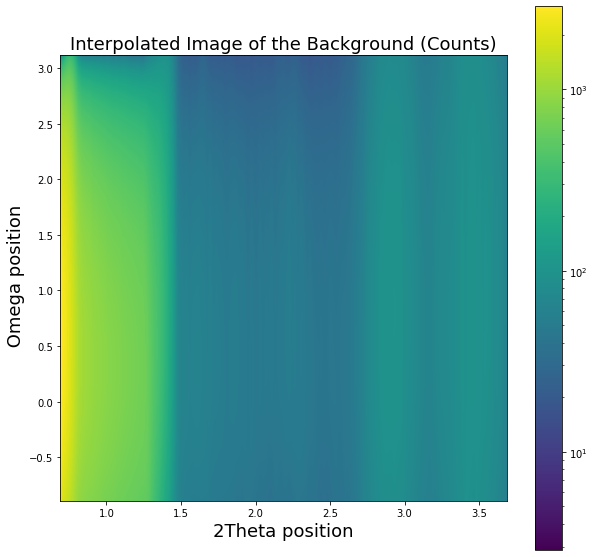

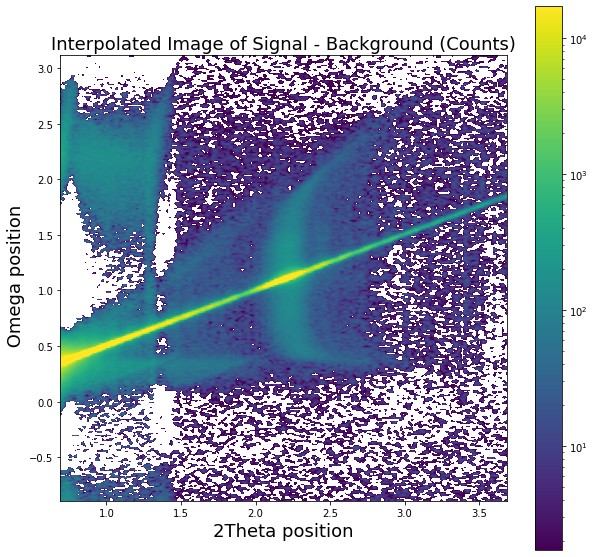

In [8]:
# an approach to produce an interpolated image of the background
grid_x, grid_y = np.mgrid[np.min(x):np.max(x):256j,np.min(y):np.max(y):256j]
points = np.zeros((len(x),2))
points[:,0] = x
points[:,1] = y
#grid_z0 = griddata(points, Background0, (grid_x,grid_y), method='nearest')
grid_z0 = griddata(points, Background0, (grid_x,grid_y), method='linear')
#grid_z0 = griddata(points, Background0, (grid_x,grid_y), method='cubic')
grid_z0 = np.nan_to_num(grid_z0) # convert NaN to 0

plt.figure(figsize = (10,10))
plt.xlabel(xAxisTitle,fontsize=18)
plt.ylabel(yAxisTitle,fontsize=18)
plt.title('Interpolated Image of the Background (Counts)',fontsize=18)
#plt.imshow(np.transpose(grid_z0,axes=[1,0]), extent=[np.min(x),np.max(x),np.min(y),np.max(y)], aspect=(np.max(x)-np.min(x))/(np.max(y)-np.min(y)), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=np.max(grid_z0)))
plt.imshow(np.transpose(grid_z0,axes=[1,0]), extent=[np.min(x),np.max(x),np.min(y),np.max(y)], aspect=(np.max(x)-np.min(x))/(np.max(y)-np.min(y)), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=0.001*np.max(grid_z0), vmax=np.max(grid_z0)))
plt.colorbar()
plt.show()

# produce interpolated image of signal - background
#grid_z0 = griddata(points, z_net, (grid_x,grid_y), method='nearest')
grid_z0 = griddata(points, z_net, (grid_x,grid_y), method='linear')
#grid_z0 = griddata(points, z_net, (grid_x,grid_y), method='cubic')
grid_z0 = np.nan_to_num(grid_z0) # convert NaN to 0

plt.figure(figsize = (10,10))
plt.xlabel(xAxisTitle,fontsize=18)
plt.ylabel(yAxisTitle,fontsize=18)
plt.title('Interpolated Image of Signal - Background (Counts)',fontsize=18)
#plt.imshow(np.transpose(grid_z0,axes=[1,0]), extent=[Qxmin,Qxmax,Qzmin,Qzmax], aspect=(Qxmax-Qxmin)/(Qzmax-Qzmin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=1*np.max(grid_z0)))
plt.imshow(np.transpose(grid_z0,axes=[1,0]), extent=[np.min(x),np.max(x),np.min(y),np.max(y)], aspect=(np.max(x)-np.min(x))/(np.max(y)-np.min(y)), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=1e-6*np.max(grid_z0), vmax=1e-2*np.max(grid_z0)))
plt.colorbar()
plt.show()

## From the raw data calculate Qx, Qz
Geometry:
    
    1) Sample surface assumed horizontal.
    
    2) Omega is the angle from surface to the incident wavevector.
    
    3) 2Theta is the angle subtending incident and scattering wavevector.
    
    4) Angles are positive if they rotate in counterclockwise orientation.

In [9]:
# Omega sign from panalytic is opposite to our definitions
phi = -y * Pi/180.
two_theta = x * Pi/180.
kix, kiz = 2*Pi/WaveLength*np.cos(phi),           2*Pi/WaveLength*np.sin(phi)
kfx, kfz = 2*Pi/WaveLength*np.cos(two_theta+phi), 2*Pi/WaveLength*np.sin(two_theta+phi)
Qx, Qz = kfx-kix, kfz-kiz  

## Form the Qx-Qz-binned data and plot the images

The Qx-Qz-binned data will be contained in "S" (its variance in "VarS") with coordinates "QX" and "QZ".

The number of Qx bins (=u) and Qz bins (=v) can be changed by the user.

The determinant of the Jacobian of the transformation, "J", records the instances multiple real space elements are
mapped to the same Qx-Qz bin.

Two images are plotted. The first is of the binned data ("S"); the second uses a scipy grid interpolation method operating
directly on "z_net"--the background subtracted unbinned data set.

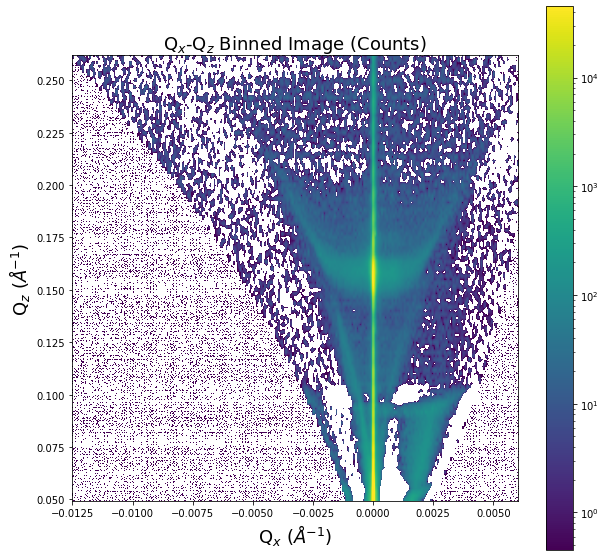

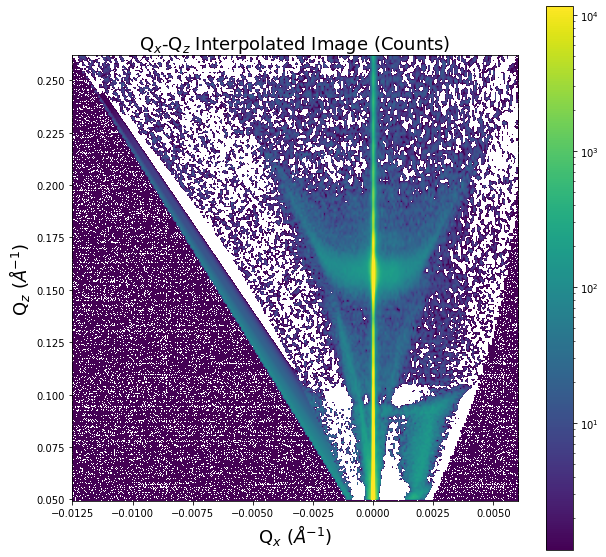

In [10]:
Qxmin, Qzmin = np.min(Qx),np.min(Qz)
Qxmax, Qzmax = np.max(Qx),np.max(Qz)
u,v = 256, 128 # these are the number of Qx and Qz bins, can be changed by the USER
QX,QZ = np.arange(u)*(Qxmax - Qxmin)/(u-1) + Qxmin, np.arange(v)*(Qzmax - Qzmin)/(v-1) + Qzmin

S = np.zeros((u,v), dtype=np.float32)
VarS = np.zeros((u,v), dtype=np.float32)
J = np.zeros((u,v), dtype=np.int32)
for i in range(m):
    h,k = find_nearest(QX,Qx[i])
    h,l = find_nearest(QZ,Qz[i])
    S[k,l] = S[k,l] + z_net[i]
    VarS[k,l] = VarS[k,l] + var_z_net[i]
    J[k,l] = J[k,l] + 1

idx = np.argwhere(J==0)
J[idx[:,0],idx[:,1]] = 1
S = S / J # this accounts for the change of mapping of elements from real to reciprocal space
VarS = VarS / J**2 # this accounts for the change of mapping of elements from real to reciprocal space

plt.figure(figsize = (10,10))
plt.xlabel('Q$_x$ ($\AA$$^{-1}$)',fontsize=18)
plt.ylabel('Q$_z$ ($\AA$$^{-1}$)',fontsize=18)
plt.title('Q$_x$-Q$_z$ Binned Image (Counts)',fontsize=18)
#plt.imshow(np.transpose(S,axes=[1,0]), extent=[Qxmin,Qxmax,Qzmin,Qzmax], aspect=(Qxmax-Qxmin)/(Qzmax-Qzmin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=np.max(S)))
plt.imshow(np.transpose(S,axes=[1,0]), extent=[Qxmin,Qxmax,Qzmin,Qzmax], aspect=(Qxmax-Qxmin)/(Qzmax-Qzmin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=0.000001*np.max(S), vmax=np.max(S)/10))
plt.colorbar()
plt.show()

# an approach to produce an interpolated image
grid_QX, grid_QZ = np.mgrid[np.min(QX):np.max(QX):256j,np.min(QZ):np.max(QZ):256j]
points = np.zeros((len(Qx),2))
points[:,0] = Qx
points[:,1] = Qz
#grid_z0 = griddata(points, z_net, (grid_QX,grid_QZ), method='nearest')
grid_z0 = griddata(points, z_net, (grid_QX,grid_QZ), method='linear')
#grid_z0 = griddata(points, z_net, (grid_QX,grid_QZ), method='cubic')
grid_z0 = np.nan_to_num(grid_z0) # convert NaN to 0

plt.figure(figsize = (10,10))
plt.xlabel('Q$_x$ ($\AA$$^{-1}$)',fontsize=18)
plt.ylabel('Q$_z$ ($\AA$$^{-1}$)',fontsize=18)
plt.title('Q$_x$-Q$_z$ Interpolated Image (Counts)',fontsize=18)
#plt.imshow(np.transpose(grid_z0,axes=[1,0]), extent=[Qxmin,Qxmax,Qzmin,Qzmax], aspect=(Qxmax-Qxmin)/(Qzmax-Qzmin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=1*np.max(grid_z0)))
plt.imshow(np.transpose(grid_z0,axes=[1,0]), extent=[Qxmin,Qxmax,Qzmin,Qzmax], aspect=(Qxmax-Qxmin)/(Qzmax-Qzmin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=1e-6*np.max(grid_z0), vmax=1e-2*np.max(grid_z0)))
plt.colorbar()
plt.show()

## Write the results to output files.
Data are written to numpy binary files and to matlab formatted files.

In [11]:
np.savez(OutputFileBase+'.npz',x=x,y=y,z=z,var_z=var_z,z_net=z_net,var_z_net=var_z_net,Qx=Qx,Qz=Qz,QX=QX,QZ=QZ,S=S,VarS=VarS)
sio.savemat(OutputFileBase+'.mat',{'x':x,'y':y,'z':z,'var_z':var_z,'z_net':z_net,'var_z_net':var_z_net,\
                                   'Qx':Qx,'Qz':Qz,'QX':QX,'QZ':QZ,'S':S,'VarS':VarS})

## Plot a cut for fixed Qx and Qz

Examples of plots showing different Qx and Qz cuts across the Qx-Qz binned data for the example data set.

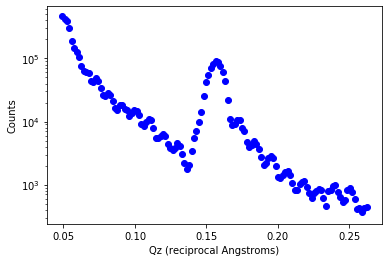

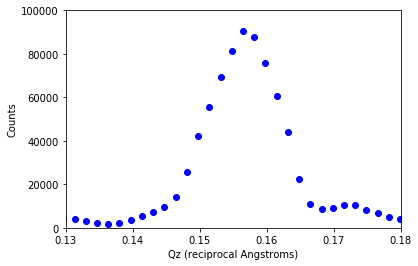

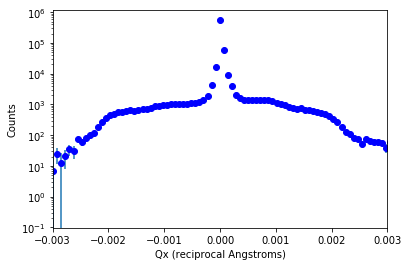

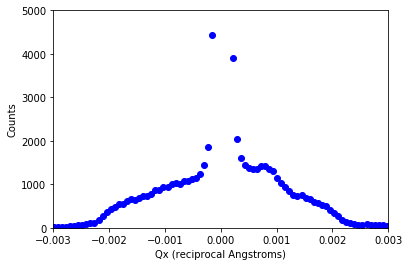

In [12]:
qx_tar = 0.
h,idx = find_nearest(QX,qx_tar) # find index corresponding to QX=0, on the specular ridge

sqz = np.sum(S[idx-2:idx+2,:],axis=0)
var_sqz = np.sum(VarS[idx-2:idx+2,:],axis=0)
rms_sqz = np.sqrt(var_sqz)

plt.yscale('log')
plt.xlabel('Qz (reciprocal Angstroms)')
plt.ylabel('Counts')
plt.plot(QZ,sqz,'bo')
plt.errorbar(QZ,sqz,rms_sqz,fmt='none')
plt.show()

plt.xlabel('Qz (reciprocal Angstroms)')
plt.ylabel('Counts')
plt.xlim((0.13,0.18))
plt.ylim((0,1e5))
plt.plot(QZ,sqz,'bo')
plt.errorbar(QZ,sqz,rms_sqz,fmt='none')
plt.show()

sqx = np.sum(S[:,60:70],axis=1) # the indices of 60:70 encompass the superlattice reflection for the example data.
var_sqx = np.sum(VarS[:,60:70],axis=1)
rms_sqx = np.sqrt(var_sqx)

plt.xlabel('Qx (reciprocal Angstroms)')
plt.ylabel('Counts')
plt.yscale('log')
plt.xlim((-0.003,0.003))
#plt.ylim((0,1000))
plt.plot(QX,sqx,'bo')
plt.errorbar(QX,sqx,rms_sqx,fmt='none')
plt.show()

plt.xlabel('Qx (reciprocal Angstroms)')
plt.ylabel('Counts')
plt.yscale('linear')
plt.ylim((0,5000))
plt.xlim((-0.003,0.003))
plt.plot(QX,sqx,'bo')
plt.errorbar(QX,sqx,rms_sqx,fmt='none')
plt.show()
